In [1]:
import baltic as bt
import pandas as pd
import json
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import requests
from io import StringIO as sio

In [2]:
#this converts fasta files into dataframes
def fasta_to_df(fasta_file):
    
    fasta_data = []
    
    with open(fasta_file) as f:
        header = ""
        sequence = ""
        for line in f:
            if line.startswith(">"):
                if header != "":
                    fasta_data.append({"header": header, "sequence": sequence})
                header = line.strip() 
                sequence = ""
            else:
                sequence += line.strip()
        fasta_data.append({"header": header, "sequence": sequence}) #last line
            
    return pd.DataFrame(fasta_data)

In [3]:
china_list = ['Beijing','Nanjing','Tianjin', 'Fujian','Guangzhou','Liaoning',
              'China','Guangdong', 'Hainan', 'Heilongjiang','Henan', 'Jiangsu',
              'Shanghai', 'Shanxi', 'Zhejiang']

korea_list = ['Korea', 'SouthKorea']

USA_list = ['Alabama', 'Texas', 'California', 'Nevada', 'Florida', 'Georgia','Indiana','Kentucky',
            'NorthCarolina', 'SouthCarolina','Illinois', 'Pennsylvania', 'Minnesota','Oklahoma'
            'NewJersey', 'NewYork', 'Ohio', 'Tennessee', 'USA' , 'Virginia', 'WestVirginia', 
            'Wisconsin']

canada_list = ['Ontario']

In [4]:
#had to change file name to match his regex expression lol
def load_tree():
    nexusPath=f'./bootstraps/bootstrap1/rootedHA_unrootedsegments/bootstrap1.annotated.tre'
    mytree = bt.loadNexus(nexusPath, tip_regex='\|([0-9\-]+)$', absoluteTime= False, verbose=True)
    return(mytree)

In [5]:
mytree = load_tree()
mytree.treeStats()

# names = []
# #print(k.name.split('|')[0])
# for k in mytree.Objects:
#     if k.branchType == "leaf":
#         names.append(k.name.split("_")[1] if k.name.split("_")[0] == 'feline' else k.name.split("_")[0])

# for practice
for k in mytree.Objects:
    if k.branchType == "leaf" and k.traits["is_reassorted"]: #can also be =="node"
        print(k.parent)
        
            

File should contain 297 taxa
Identified tree string

Tree height: 0.040174
Tree length: 0.354343
strictly bifurcating tree
annotations present

Numbers of objects in tree: 593 (296 nodes and 297 leaves)



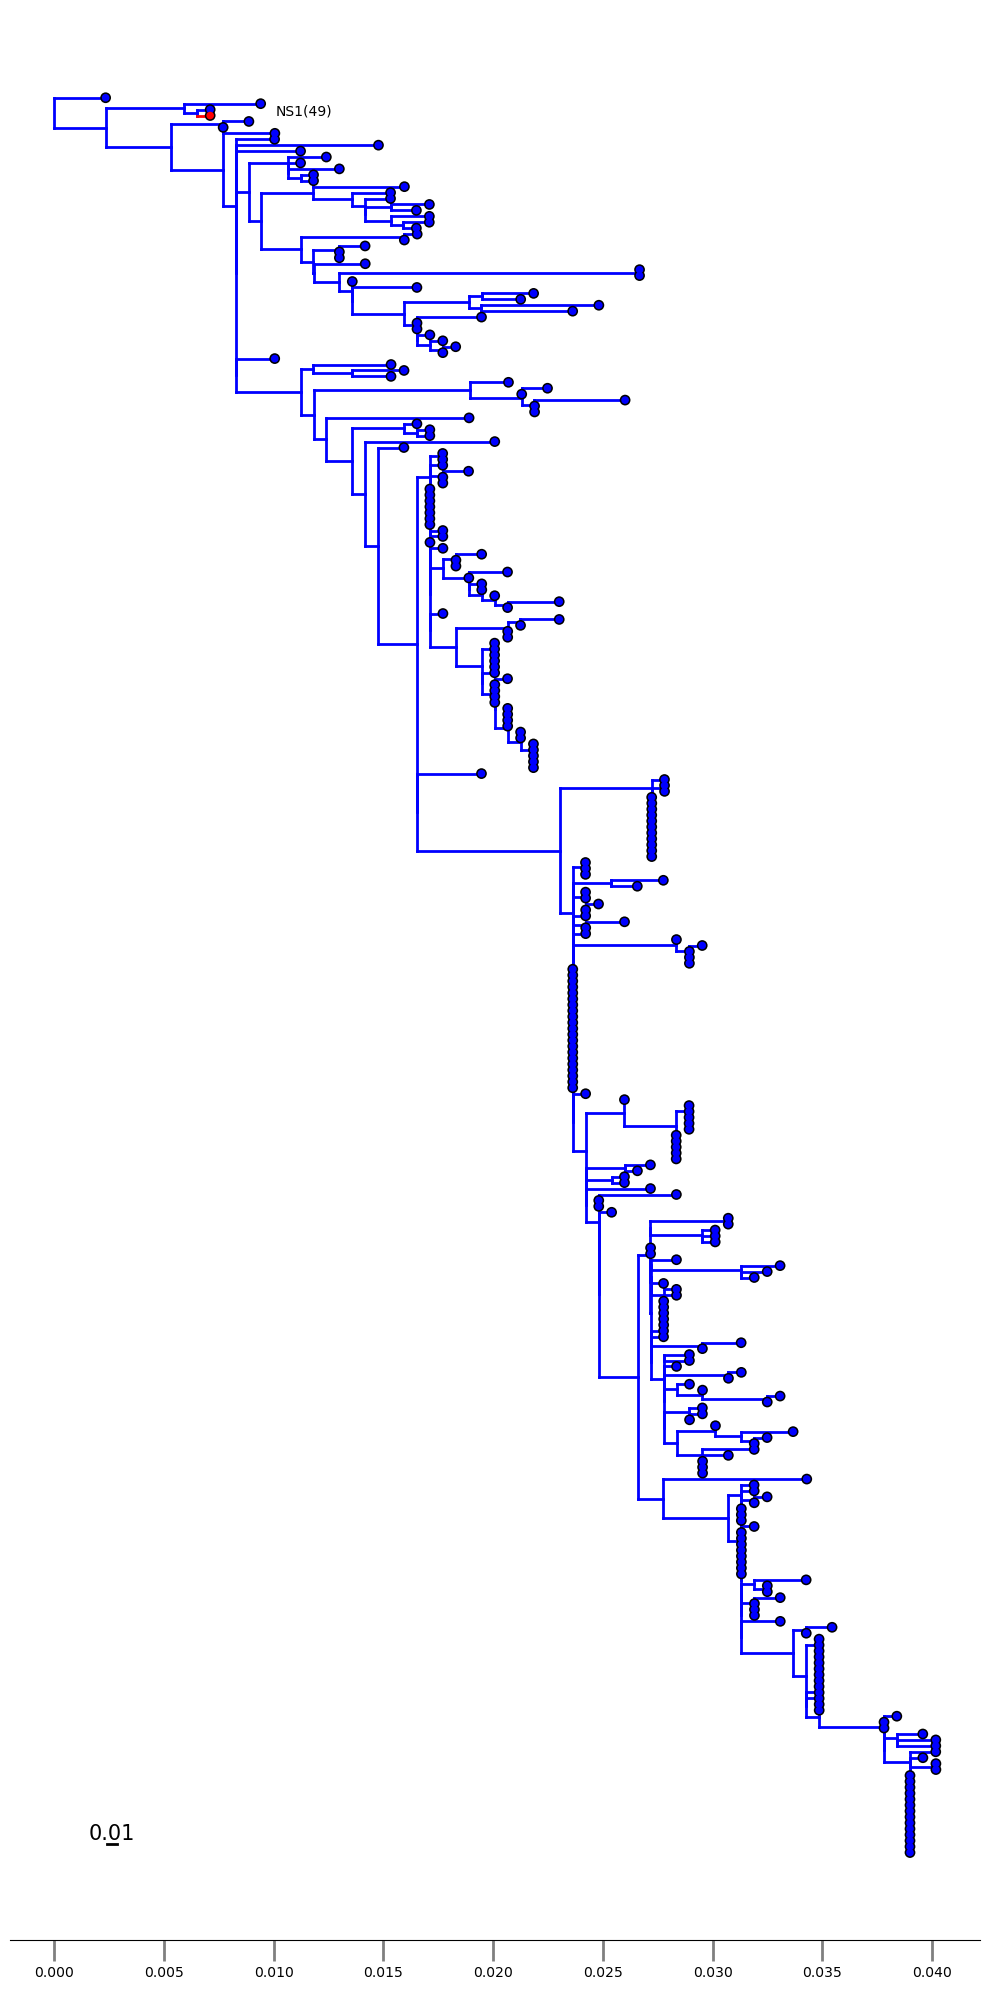

In [6]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')

#kwargs={'size': 20} ## kwargs for text

x_attr=lambda k: k.x

print(k)

c_func=lambda k: 'red' if k.traits['is_reassorted'] == 1 else 'blue' ## 
cbranch_func = lambda k: 'red' if k.traits['is_reassorted'] == 1 else 'blue'

mytree.plotTree(ax,x_attr=x_attr, colour=cbranch_func) ## tree
mytree.plotPoints(ax,x_attr=x_attr,size=30,colour=c_func,zorder=100)
ax.plot() ## need to call plot when only drawing the tree to force drawing of line collections

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.traits['rea'] if k.traits['is_reassorted'] else "" ## what text is plotted
text_x_attr=lambda k: k.x+0.003 ## where x coordinate for text is
mytree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func, size='10')

# Adding scale bar
scale_length = 0.01
x_min, x_max = ax.get_xlim()
scale_x_start = x_min + (x_max - x_min) * 0.1
scale_x_end = scale_x_start + scale_length * (x_max - x_min)
scale_y = 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]) + ax.get_ylim()[0]

ax.plot([scale_x_start, scale_x_end], [scale_y, scale_y], color='black', lw=2)
ax.text((scale_x_start + scale_x_end) / 2, scale_y, f'{scale_length}', 
        ha='center', va='bottom', fontsize=15)

ax.set_yticks([])
ax.set_yticklabels([])
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.tick_params(axis='x',labelsize=10,size=15, width=2,color='grey')
fig.tight_layout()
plt.savefig("./reassortment.pdf")
plt.show()

In [7]:
def determine_color(country):
    if country in china_list:
        return 'green'
    elif country in korea_list:
        return 'blue'
    elif country in USA_list:
        return 'red'
    elif country in canada_list:
        return 'purple'

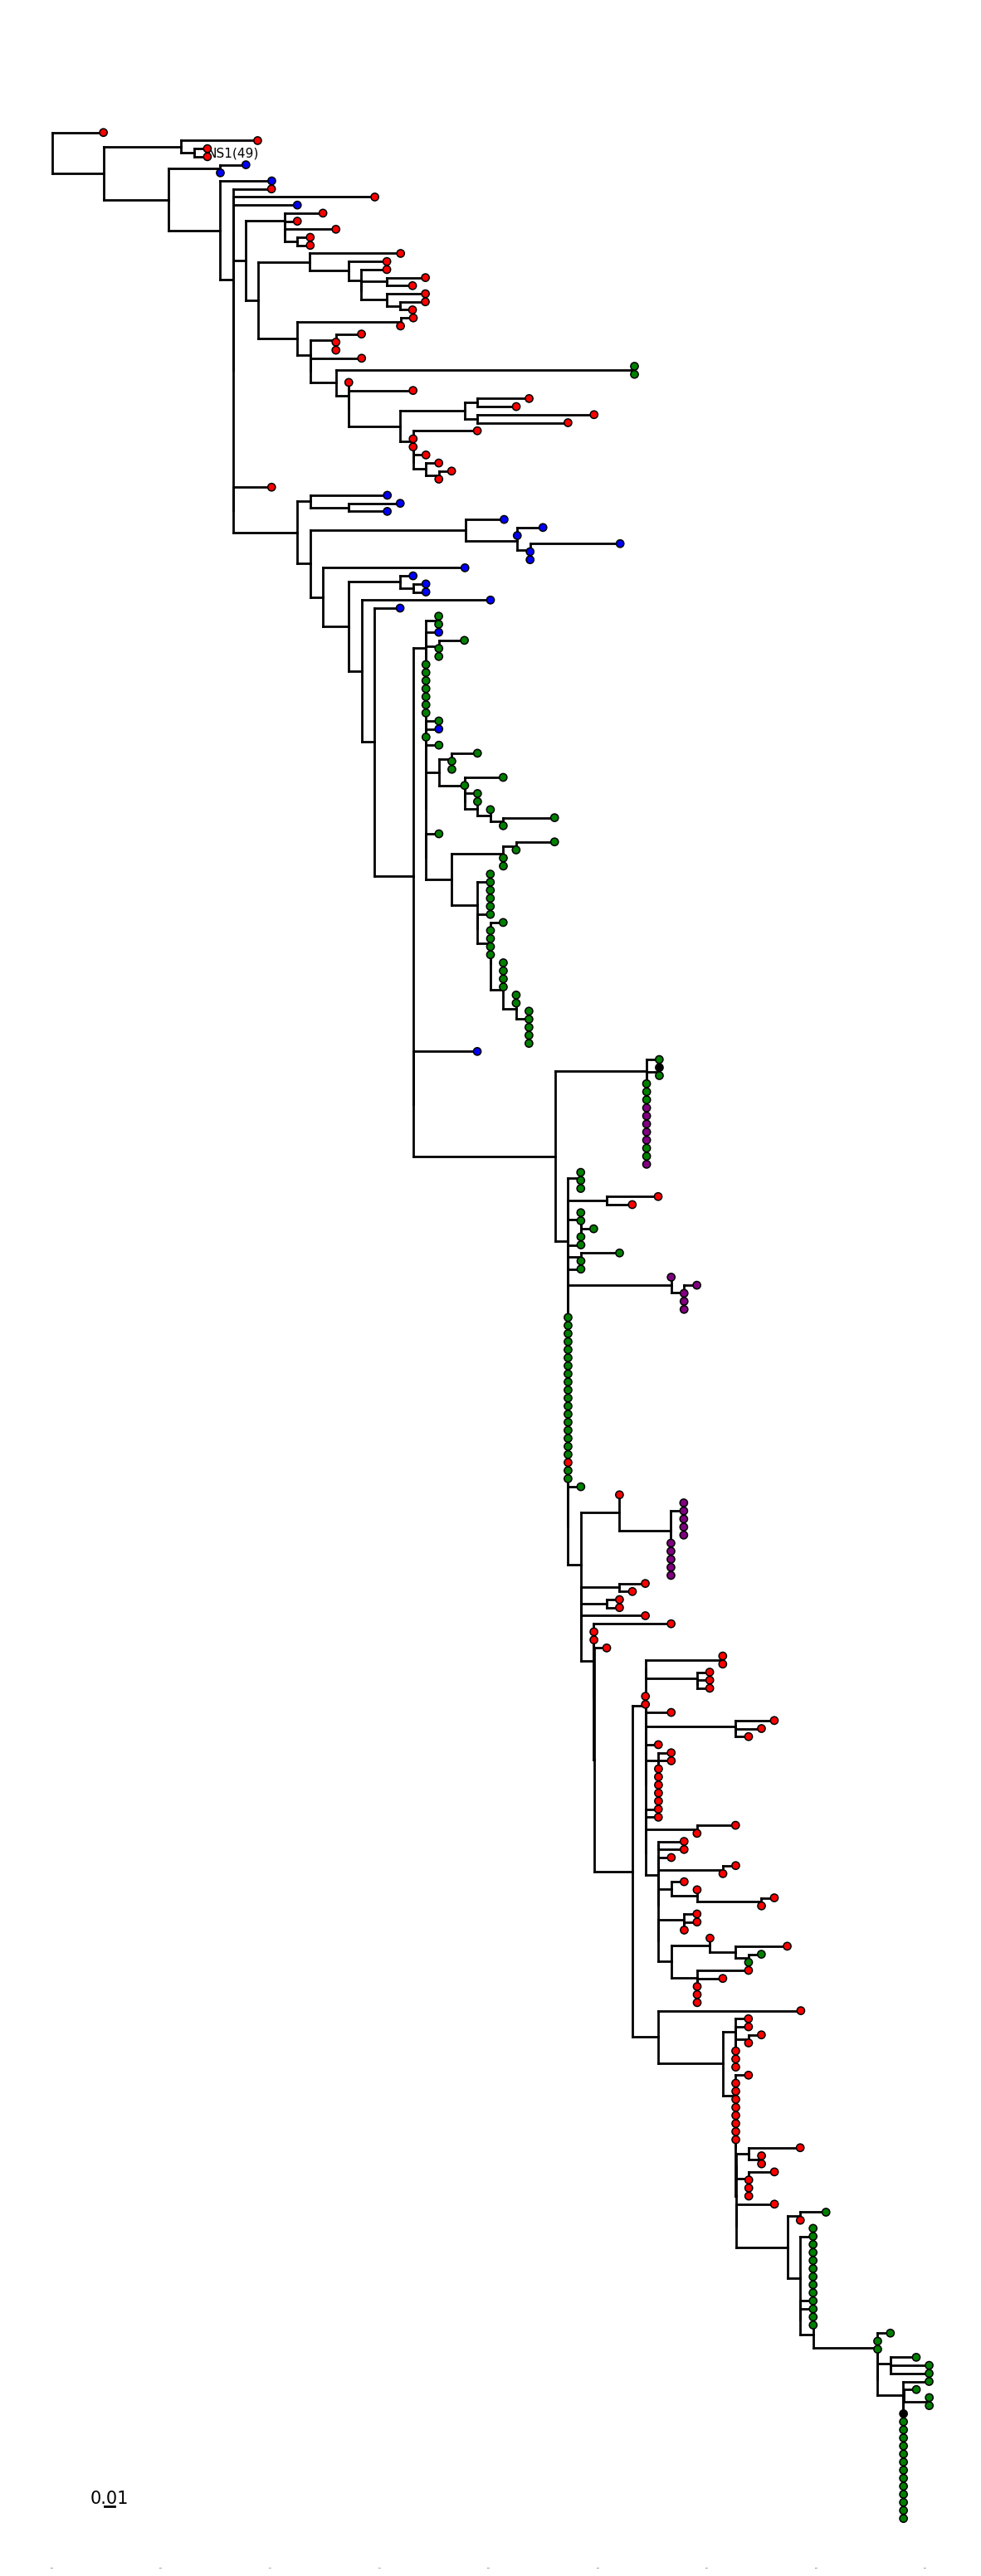

In [15]:
#this plot gets region data taken from the strain name and colors the tree by it

fig, ax = plt.subplots(figsize=(15, 40), facecolor='w')

x_attr = lambda k: k.x

c_func = lambda k: determine_color(k.name.split("_")[1] if k.name.split("_")[0] == 'feline' else k.name.split("_")[0])

mytree.plotTree(ax, x_attr=x_attr,colour = 'k')
mytree.plotPoints(ax, x_attr=x_attr, size=30, colour=c_func, zorder=100)

target_func = lambda k: k.is_leaf()  # Which branches will be annotated
text_func = lambda k: k.traits['rea'] if k.traits['is_reassorted'] else ""  #plotting ns1 reassorted text

text_x_attr=lambda k: k.x+0.0003
mytree.addText(ax, x_attr=x_attr, target=target_func, text=text_func, size = '11')

#scale bar
scale_length = 0.01
x_min, x_max = ax.get_xlim()
scale_x_start = x_min + (x_max - x_min) * 0.1
scale_x_end = scale_x_start + scale_length * (x_max - x_min)
scale_y = 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]) + ax.get_ylim()[0]

ax.plot([scale_x_start, scale_x_end], [scale_y, scale_y], color='black', lw=2)
ax.text((scale_x_start + scale_x_end) / 2, scale_y, f'{scale_length}', 
        ha='center', va='bottom', fontsize=15)

ax.set_ylim(-5,mytree.ySpan+15)

ax.set_yticks([])
ax.set_yticklabels([])
[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.tick_params(axis='x', labelsize=0, size=0, width=0, color='grey')

# plt.show()
plt.savefig("./region_plot_only_for_editing.pdf")


In [404]:
target_tips = set(["Guangdong_2_2006","Guangdong_1_2007","Guangdong_2_2007"])

In [407]:
def return_subtree(node, tree):
    subtree=tree.subtree(node) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
    if subtree != None:
        subtree.traverse_tree()
        subtree.sortBranches()
        return(subtree)

In [410]:
for k in mytree.Objects: 
    if k.branchType == "node":
        leaf_names = []
        for l in k.leaves: 
            name = l.split("|")[0]
            leaf_names.append(name)
        
        if set(leaf_names) == target_tips:
            subtree = return_subtree(k, mytree)
print(subtree)

In [411]:
for k in subtree.Objects: 
    print(k)